This has the same content as the simple_model_synthetc_data.py file, but it is moved into a notebook so that it is easier & more intuitive to perform data analysis on.

In [1]:
# imports
import argparse
from argparse import Namespace

from pytorch_lightning import Trainer, LightningModule, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

from yeastdnnexplorer.data_loaders.synthetic_data_loader import SyntheticDataLoader
from yeastdnnexplorer.ml_models.simple_model import SimpleModel

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set random seed for reproducibility
seed_everything(42)

Seed set to 42


42

Here we define checkpoints and loggers for our model. The checkpoints specify when to save instancces of the model (to be inspected later if we'd like) and the loggers specify different ways that we save the metric data that is output by the models during training.

In [3]:
# define checkpoints for the model
# tells it when to save snapshots of the model during training
# Callback to save the best model based on validation loss
best_model_checkpoint = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    filename="best-model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
)

# Callback to save checkpoints every 5 epochs, regardless of performance
periodic_checkpoint = ModelCheckpoint(
    filename="periodic-{epoch:02d}",
    every_n_epochs=2,
    save_top_k=-1,  # Setting -1 saves all checkpoints
)

In [4]:
# configure loggers
tb_logger = TensorBoardLogger("logs/tensorboard_logs")
csv_logger = CSVLogger("logs/csv_logs")

We now define a basic function to run our experiment. The function takes many parameters that allow you to shape the distribution of the in silico data used to train the model with.

In [5]:
from torchsummary import summary


def simple_model_synthetic_data_experiment(
    batch_size: int,
    lr: float,
    max_epochs: int,
    using_random_seed: bool,
    accelerator: str,
    num_genes: int,
    signal_mean: float,
    val_size: float,
    test_size: float,
    signal: list[float],
    n_sample: list[int],
) -> LightningModule:
    """
    Trains a SimpleModel on synthetic data and saves the best model based on validation
    loss. Defines an instance of Trainer, which is used to train the model with the
    given dataModule. While much of the training process is captured via logging, we
    also print the test results at the end of training. We don't need to do assrtions
    for type checking, as this was done in the parse_args_for_synthetic_data_experiment
    function.

    :param batch_size: The batch size to use for training
    :type batch_size: int
    :param lr: The learning rate to use for training
    :type lr: float
    :param max_epochs: The maximum number of epochs to train for
    :type max_epochs: int
    :param using_random_seed: Whether or not to use a random seed for reproducibility
    :type using_random_seed: bool
    :param accelerator: The accelerator to use for training (e.g. 'gpu', 'cpu')
    :type accelerator: str
    :param num_genes: The number of genes to generate synthetic data for (rows of matrix)
    :type num_genes: int
    :param signal_mean: The mean of the signal to use for generating synthetic data
    :type signal_mean: float
    :param val_size: The proportion of the data to use for validation
    :type val_size: float
    :param test_size: The proportion of the data to use for testing
    :type test_size: float
    :param signal: The percentage of each sample to put in the signal group
    :type signal: list[float]
    :param n_sample: The number of samples to generate for each signal group, the sum of which is the number of TFs
    :type n_sample: list[int]

    """

    data_module = SyntheticDataLoader(
        batch_size=batch_size,
        num_genes=num_genes,
        signal_mean=signal_mean,
        signal=signal,  # old: [0.1, 0.15, 0.2, 0.25, 0.3],
        n_sample=n_sample,  # sum of this is num of tfs
        val_size=val_size,
        test_size=test_size,
        random_state=42,
    )

    num_tfs = sum(data_module.n_sample)  # sum of all n_sample is the number of TFs

    model = SimpleModel(input_dim=num_tfs, output_dim=num_tfs, lr=lr)
    trainer = Trainer(
        max_epochs=max_epochs,
        deterministic=using_random_seed,
        accelerator=accelerator,
        callbacks=[best_model_checkpoint, periodic_checkpoint],
        logger=[tb_logger, csv_logger],
    )
    trainer.fit(model, data_module)

    test_results = trainer.test(model, datamodule=data_module)
    print("Printing test results...")
    print(
        test_results
    )  # this prints all metrics that were logged during the test phase

    # print summary of model
    print("Printing model summary...")
    summary(model, (num_tfs, num_tfs))

    return model, test_results

In [6]:
# Set values and run the experiment

simple_model_synthetic_data_experiment(
    batch_size=32,
    lr=0.01,
    max_epochs=10,
    using_random_seed=True,
    accelerator="cpu",
    num_genes=1000,
    val_size=0.1,
    test_size=0.1,
    signal=[0.5] * 5,  # old: [0.1, 0.15, 0.2, 0.25, 0.3]
    n_sample=[1, 1, 2, 2, 4],  # sum of this is num of tfs
    signal_mean=3.0,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, Y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(
/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/yeastdnnexplorer/data_loaders/synthetic_data_loader.py:253: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val, Y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(
/Users/benmueller/2024Classes/BrentResearch/git

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.969958782196045
        test_mape            6.095639705657959
       test_nrmse           0.2585620582103729
         test_r2           -0.08068642020225525
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing test results...
[{'test_loss': 1.969958782196045, 'test_nrmse': 0.2585620582103729, 'test_mape': 6.095639705657959, 'test_r2': -0.08068642020225525}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainabl

(SimpleModel(
   (mape): MeanAbsolutePercentageError()
   (r2): R2Score()
   (linear1): Linear(in_features=10, out_features=10, bias=True)
 ),
 [{'test_loss': 1.969958782196045,
   'test_nrmse': 0.2585620582103729,
   'test_mape': 6.095639705657959,
   'test_r2': -0.08068642020225525}])

We can now run experiements using this function, such as the following one to see how mse changes as a function of the signal (bound genes) mean. This will create a lot of output as we are training several models here.

In [7]:
signal_means = [0.5, 1.0, 2.0, 3.0, 5.0]
# mse = []
mapes = []
for signal_mean in signal_means:
    model, test_results = simple_model_synthetic_data_experiment(
        batch_size=32,
        lr=0.01,
        max_epochs=10,
        using_random_seed=True,
        accelerator="cpu",
        num_genes=1000,
        val_size=0.1,
        test_size=0.1,
        signal=[0.5] * 5,  # old: [0.1, 0.15, 0.2, 0.25, 0.3],   # [0.5] * 5
        n_sample=[1, 1, 2, 2, 4],  # sum of this is num of tfs    # [1, 1, 2, 2, 4]
        signal_mean=signal_mean,  # this is the perturb effect signal mean
    )
    print(test_results)
    # mse.append(test_results[0]["test_loss"])
    mapes.append(test_results[0]["test_mape"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/benmueller/2024Classes/BrentResearch/git_repos/yeastdnnexplorer/.venv/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory logs/tensorboard_logs/lightning_logs/version_84/checkpoints exists and is not empty.

  | Name    | Type                        | Params
--------------------------------------------------------
0 | mape    | MeanAbsolutePercentageError | 0     
1 | r2      | R2Score                     | 0     
2 | linear1 | Linear                      | 110   
--------------------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.40072378516197205
        test_mape            6.020374774932861
       test_nrmse           0.20038776099681854
         test_r2           -0.02892213873565197
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                        | Params
--------------------------------------------------------
0 | mape    | MeanAbsolutePercentageError | 0     
1 | r2      | R2Score                     | 0     
2 | linear1 | Linear                      | 110   
--------------------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_loss': 0.40072378516197205, 'test_nrmse': 0.20038776099681854, 'test_mape': 6.020374774932861, 'test_r2': -0.02892213873565197}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[{'test_loss': 0.40072378516197205, 'test_nrmse': 0.20038776099681854, 'test_mape': 6.020374774932861, 'test_r2': -0.02892213873565197}]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5322389006614685
        test_mape            7.097254276275635
       test_nrmse           0.20397989451885223
         test_r2           -0.008763633668422699
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                        | Params
--------------------------------------------------------
0 | mape    | MeanAbsolutePercentageError | 0     
1 | r2      | R2Score                     | 0     
2 | linear1 | Linear                      | 110   
--------------------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_loss': 0.5322389006614685, 'test_nrmse': 0.20397989451885223, 'test_mape': 7.097254276275635, 'test_r2': -0.008763633668422699}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[{'test_loss': 0.5322389006614685, 'test_nrmse': 0.20397989451885223, 'test_mape': 7.097254276275635, 'test_r2': -0.008763633668422699}]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0530120134353638
        test_mape               11.0859375
       test_nrmse           0.21493397653102875
         test_r2           -0.00693657249212265
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                        | Params
--------------------------------------------------------
0 | mape    | MeanAbsolutePercentageError | 0     
1 | r2      | R2Score                     | 0     
2 | linear1 | Linear                      | 110   
--------------------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_loss': 1.0530120134353638, 'test_nrmse': 0.21493397653102875, 'test_mape': 11.0859375, 'test_r2': -0.00693657249212265}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[{'test_loss': 1.0530120134353638, 'test_nrmse': 0.21493397653102875, 'test_mape': 11.0859375, 'test_r2': -0.00693657249212265}]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.0612733364105225
        test_mape           19.315452575683594
       test_nrmse           0.2494332194328308
         test_r2           -0.06315205246210098
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                        | Params
--------------------------------------------------------
0 | mape    | MeanAbsolutePercentageError | 0     
1 | r2      | R2Score                     | 0     
2 | linear1 | Linear                      | 110   
--------------------------------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_loss': 2.0612733364105225, 'test_nrmse': 0.2494332194328308, 'test_mape': 19.315452575683594, 'test_r2': -0.06315205246210098}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[{'test_loss': 2.0612733364105225, 'test_nrmse': 0.2494332194328308, 'test_mape': 19.315452575683594, 'test_r2': -0.06315205246210098}]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            5.552483558654785
        test_mape            17.4146785736084
       test_nrmse           0.30458635091781616
         test_r2           -0.09196291863918304
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing test results...
[{'test_loss': 5.552483558654785, 'test_nrmse': 0.30458635091781616, 'test_mape': 17.4146785736084, 'test_r2': -0.09196291863918304}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainabl

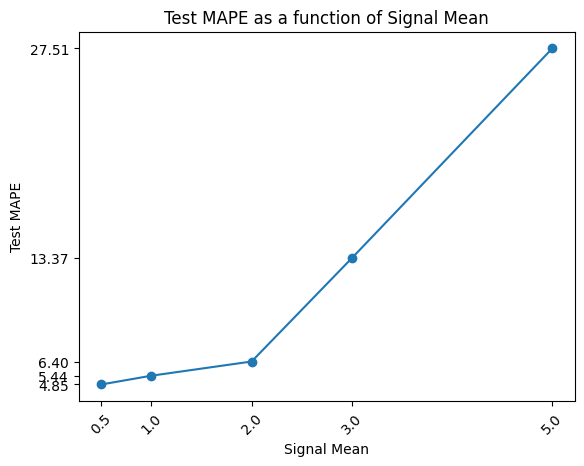

In [7]:
# plotting results of experiment
plt.plot(signal_means, mapes, marker="o")
plt.xlabel("Signal Mean")
plt.xticks(signal_means, rotation=45)
plt.yticks(mapes)
# plt.ylabel("Test MSE")
# plt.title("Test MSE as a function of Signal Mean")
plt.ylabel("Test R^2")
plt.title("Test R^2 as a function of Signal Mean")
plt.show()

Experiment to test the signal/noise ratio's effect on the MSE

In [9]:
# these nums are the percentage of data put into the signal group
# we will train and test a model for each of these values
signal_noise_ratios = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9]
mses = []

for signal_noise_ratio in signal_noise_ratios:
    model, test_results = simple_model_synthetic_data_experiment(
        batch_size=32,
        lr=0.01,
        max_epochs=10,
        using_random_seed=True,
        accelerator="cpu",
        num_genes=1000,
        val_size=0.1,
        test_size=0.1,
        signal=[signal_noise_ratio]
        * 5,  # old: [0.1, 0.15, 0.2, 0.25, 0.3],   # [0.5] * 5
        n_sample=[1, 1, 2, 2, 4],  # sum of this is num of tfs    # [1, 1, 2, 2, 4]
        signal_mean=3.0,  # this is the perturb effect signal mean
    )
    print(test_results)
    mses.append(test_results[0]["test_loss"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 110   
-----------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6579614877700806
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 110   
-----------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_loss': 0.6579614877700806}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[{'test_loss': 0.6579614877700806}]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8236812353134155
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 110   
-----------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_loss': 0.8236812353134155}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[{'test_loss': 0.8236812353134155}]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.3657211065292358
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 110   
-----------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_loss': 1.3657211065292358}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[{'test_loss': 1.3657211065292358}]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            2.200093984603882
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 110   
-----------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_loss': 2.200093984603882}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[{'test_loss': 2.200093984603882}]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           2.1631276607513428
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type   | Params
-----------------------------------
0 | linear1 | Linear | 110   
-----------------------------------
110       Trainable params
0         Non-trainable params
110       Total params
0.000     Total estimated model params size (MB)


Printing test results...
[{'test_loss': 2.1631276607513428}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[{'test_loss': 2.1631276607513428}]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.9268033504486084
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Printing test results...
[{'test_loss': 1.9268033504486084}]
Printing model summary...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 10, 10]             110
Total params: 110
Trainable params: 110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------

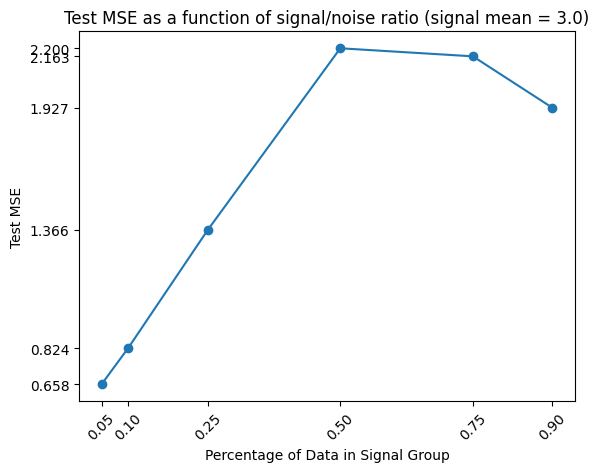

In [10]:
# plottig results of experiment
plt.plot(signal_noise_ratios, mses, marker="o")
plt.xlabel("Percentage of Data in Signal Group")
plt.ylabel("Test MSE")
plt.xticks(signal_noise_ratios, rotation=45)
plt.yticks(mses)
plt.title("Test MSE as a function of signal/noise ratio (signal mean = 3.0)")

plt.show()